<a href="https://colab.research.google.com/github/maya-halevy/Kaggle-Contrails/blob/main/BaselineModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import libraries
import numpy as np
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Set the path to the train folder
train_folder = '/content/drive/MyDrive/contrails_data/train_xs'

In [4]:
# Initialize lists to store the pixel arrays and labels
images = []
labels = []

# Loop through all subdirectories in the train_folder
for subdir, dirs, files in os.walk(train_folder):
    for file in files:
        # Check if the file is the one you are looking for
        if file == 'band_12.npy':
            # Construct the full file path
            filepath = os.path.join(subdir, file)
            # Load the numpy array and append it to the list
            image = np.load(filepath)
            images.append(image)

        elif file == 'human_pixel_masks.npy':
            # Construct the full file path
            filepath = os.path.join(subdir, file)
            # Load the numpy array and append it to the list
            label = np.load(filepath)
            labels.append(label)

# Create a pandas DataFrame with the image and label lists
df = pd.DataFrame({
    'images': images,
    'labels': labels
})


In [5]:
df.head()

,images,labels
0,"[[[241.97556, 241.15376, 239.95076, 238.21529,...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
1,"[[[268.83817, 269.6395, 270.24585, 270.39383, ...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
2,"[[[266.51004, 260.8909, 266.13223, 260.5818, 2...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
3,"[[[273.36926, 273.3568, 273.26306, 273.2268, 2...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
4,"[[[247.668, 247.3644, 247.45273, 247.53923, 24...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."


In [6]:
# Data integrity check, make sure masks contain only 0 and 1

labels_array = np.array(df['labels'].tolist())
labels_flat = labels_array.flatten()
unique_values = np.unique(labels_flat)

num_unique_values = len(unique_values)
print("Number of unique values:", num_unique_values)
print("Unique values:")
print(unique_values)

Number of unique values: 2
Unique values:
[0 1]


In [7]:
df['images'][0].shape

(256, 256, 8)

In [8]:
# Add a new column 'labeled_image' that contains the 5th array

df['labeled_image'] = df['images'].apply(lambda x: x[:,:,4:5] if x.shape[2] > 4 else None)

In [9]:
# verify image dimensions
df['labeled_image'][0].shape

(256, 256, 1)

In [10]:
# EDA - check distribution of labels

num_ones = df['labels'].apply(lambda x: np.count_nonzero(x == 1))
proportion_ones = df['labels'].apply(lambda x: np.count_nonzero(x == 1) / np.size(x))
average_proportion_ones = proportion_ones.mean()

proportion_ones_filtered = proportion_ones[proportion_ones > 0]
average_proportion_ones_filtered = proportion_ones_filtered.mean()

print('Average proportion of 1s across all label arrays:', average_proportion_ones)
print()
print('Average proportion of 1s across arrays in contrails class:', average_proportion_ones_filtered)


Average proportion of 1s across all label arrays: 0.005220940140898589

Average proportion of 1s across arrays in contrails class: 0.01156708289837015


In [11]:
# Count the number of arrays with no 1's
num_arrays_no_ones = np.count_nonzero(num_ones == 0)

print('Number of arrays with no 1s:', num_arrays_no_ones)
print('Total data subset:', len(df))

Number of arrays with no 1s: 282
Total data subset: 514


Total image
- 55% of the dataset are images with no contrails (0)
- 45% are images of contrails (1)

Pixels:
- 99.5% of the total image arrays are not a contrail (0)
- 98.8% of the contrail images are not labelled as contrails (0)

In [12]:
# Split the dataset

X = df['labeled_image']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((411,), (103,), (411,), (103,))

In [13]:
# Scale the image data

scaler = MinMaxScaler()

def scale_array(arr):
    # Reshape the array to be 2D
    original_shape = arr.shape
    arr = arr.reshape(-1, 1)

    # Fit the scaler and transform the array
    arr = scaler.fit_transform(arr)

    # Reshape it back to its original shape
    return arr.reshape(original_shape)

def transform_array(arr):
    # Reshape the array to be 2D
    original_shape = arr.shape
    arr = arr.reshape(-1, 1)

    # Transform the array
    arr = scaler.transform(arr)

    # Reshape it back to its original shape
    return arr.reshape(original_shape)

In [14]:
# Scale training and test set
X_train = X_train.apply(scale_array)

X_test = X_test.apply(transform_array)

In [15]:
# Verify scaling

X_train

320    [[[0.26409483], [0.26833963], [0.26683998], [0...
329    [[[0.4197216], [0.43118095], [0.4253807], [0.4...
173    [[[0.8000159], [0.80545044], [0.7911482], [0.7...
272    [[[0.05867982], [0.050434828], [0.045659304], ...
493    [[[0.2309699], [0.20822048], [0.19506359], [0....
                             ...                        
106    [[[0.71530914], [0.72699976], [0.72238207], [0...
270    [[[0.45036697], [0.41130066], [0.34565163], [0...
348    [[[0.96162844], [0.9624038], [0.96227884], [0....
435    [[[0.89443016], [0.8942776], [0.8939915], [0.8...
102    [[[0.74688244], [0.74433327], [0.741817], [0.7...
Name: labeled_image, Length: 411, dtype: object

In [16]:
X_train.iloc[0].shape

(256, 256, 1)

In [17]:
y_train.iloc[0].shape

(256, 256, 1)

In [18]:
# Find a unet from github that solves a similar segmentation problem
# Source: https://github.com/zhixuhao/unet/blob/master/model.py
# updated input to inputs to match library updates

import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None,input_size = (256,256,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  # model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)


  return model

In [19]:
# Convert DataFrame to numpy array to match unet input requirements
X_train_np = np.stack(X_train.values)
y_train_np = np.stack(y_train.values)

print(X_train_np.shape)
print(y_train_np.shape)

(411, 256, 256, 1)
(411, 256, 256, 1)


In [20]:
# apply changes to test set
X_test_np = np.stack(X_test.values)
y_test_np = np.stack(y_test.values)

print(X_test_np.shape)
print(y_test_np.shape)


(103, 256, 256, 1)
(103, 256, 256, 1)


In [21]:
# Instantiate the model
model = unet(None,input_size = (256,256,1))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# calculate the dice coefficient

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [23]:
# Predict the test data
predictions_test = model.predict(X_test_np)

4/4 [==============================] - 247s 57s/step


In [24]:
# Convert predictions from probabilities to binary predictions and return metrics
from sklearn.metrics import recall_score, precision_score, f1_score

predictions_binary = (predictions_test > 0.5).astype(np.float32)

dice = dice_coefficient(y_test_np, predictions_binary)
recall = recall_score(y_test_np.flatten(), predictions_binary.flatten())
precision = precision_score(y_test_np.flatten(), predictions_binary.flatten())
f1 = f1_score(y_test_np.flatten(), predictions_binary.flatten())

print('Global Dice Coefficient:', dice)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)


Global Dice Coefficient: 0.0009453422844549044
Recall: 0.005405055507007153
Precision: 0.0005162750292916521
F1 Score: 0.000942523026909879


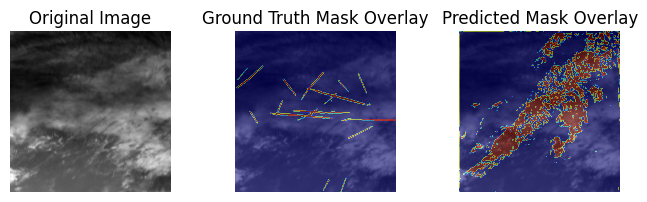

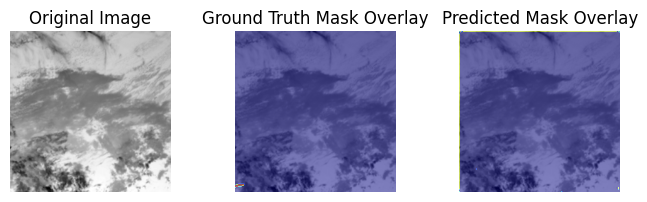

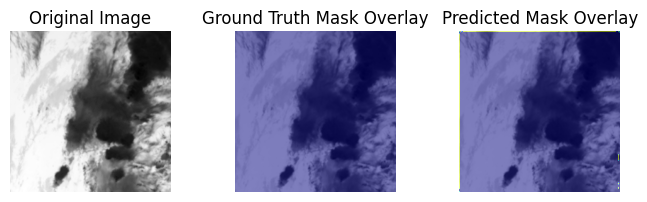

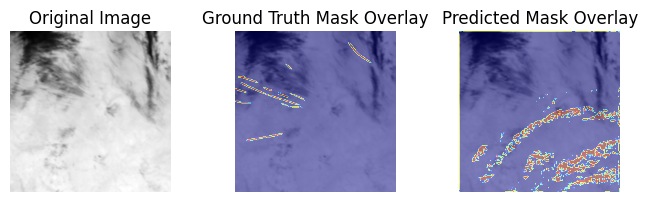

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# X_train: image data
# predictions_binary: predicted binary masks
# y_train: ground truth binary masks

# Select an example image
example_indexes = [0,24,76,80]

for example_index in example_indexes:
  example_image = X_train.iloc[example_index]

  # Select the corresponding predicted mask and ground truth mask for the example image
  example_predicted_mask = predictions_binary[example_index]
  example_ground_truth_mask = y_train.iloc[example_index]

  # Plot the original image
  plt.subplot(1, 3, 1)
  plt.imshow(example_image, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  # Plot the ground truth mask
  plt.subplot(1, 3, 2)
  plt.imshow(example_image, cmap='gray')
  plt.imshow(example_ground_truth_mask, cmap='jet', alpha=0.5)
  plt.title('Ground Truth Mask Overlay')
  plt.axis('off')

  # Plot the predicted mask overlay
  plt.subplot(1, 3, 3)
  plt.imshow(example_image, cmap='gray')
  plt.imshow(example_predicted_mask, cmap='jet', alpha=0.5)
  plt.title('Predicted Mask Overlay')
  plt.axis('off')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.4)
  plt.show()


Band 08:
- Global Dice Coefficient: 3.236e-05
(0.000032, basically 0)
- Recall: 0.0


Band 12:
- Global Dice Coefficient: 0.0009453422844549044
- Recall: 0.005405055507007153
- Precision: 0.0005162750292916521
- F1 Score: 0.000942523026909879


Band 16:
- Global Dice Coefficient: 0.0002639838089930484
- Recall: 0.00012946240735346474
